# Module 7: PCA

* DS 5001
* Raf Alvarado

# Overview

* Implement PCA from scratch
* Work with word vectors

# Set Up

## Config

We define our OHCO.

In [ ]:
OHCO = ['book_id', 'chap_num']

## Import

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import norm

In [ ]:
import plotly_express as px
import seaborn as sns

In [ ]:
sns.set(style='ticks')
%matplotlib inline

# Prepare the Data

## Import tables

We import the the small `TFIDF` table we created in a previous module. \
We import the `LIB` table because we want our visualizations to be readable. \
We import the `VOCAB` table to see which words get associated with each component.

In [ ]:
LIB = pd.read_csv('data/LIB.csv').set_index('book_id')
VOCAB = pd.read_csv('data/VOCAB2.csv').set_index('term_id')
TFIDF = pd.read_csv('data/TFIDF_REDUCED.csv').set_index(OHCO)

In [ ]:
TFIDF.shape

(1122, 3876)

# Preprocess the TFIDF Matrices

In [ ]:
TFIDF

20533      3532     21581     34916     22134     24746  \
book_id chap_num                                                               
105     1         0.000000  0.000000  0.003648  0.000000  0.004141  0.000000   
        2         0.000000  0.000000  0.000000  0.010201  0.000000  0.000000   
        3         0.000000  0.004919  0.003738  0.011887  0.008487  0.000000   
        4         0.000000  0.000000  0.000000  0.006309  0.000000  0.000000   
        5         0.000000  0.008625  0.009833  0.000000  0.000000  0.000000   
...                    ...       ...       ...       ...       ...       ...   
53861   8         0.005673  0.005615  0.000000  0.000000  0.000000  0.000000   
        11        0.006681  0.000000  0.005026  0.000000  0.002852  0.000000   
        13        0.000000  0.000000  0.000000  0.000000  0.000000  0.004469   
        14        0.004090  0.000000  0.000000  0.000000  0.000000  0.000000   
        15        0.000000  0.008752  0.000000  0.007051  0.015101  0.005061   

                     30789     12385     24524      3323  ...  25958  \
book_id chap_num                                          ...          
105     1         0.000000  0.009824  0.003621  0.000000  ...    0.0   
        2         0.000000  0.000000  0.004777  0.006141  ...    0.0   
        3         0.000000  0.000000  0.003711  0.000000  ...    0.0   
        4         0.006907  0.000000  0.000000  0.000000  ...    0.0   
        5         0.000000  0.000000  0.003254  0.004183  ...    0.0   
...                    ...       ...       ...       ...  ...    ...   
53861   8         0.004952  0.000000  0.008472  0.005446  ...    0.0   
        11        0.000000  0.000000  0.002495  0.000000  ...    0.0   
        13        0.000000  0.000000  0.011663  0.003748  ...    0.0   
        14        0.003571  0.000000  0.003055  0.011780  ...    0.0   
        15        0.000000  0.008957  0.000000  0.000000  ...    0.0   

                     32591  20661  5344  34924  36782     24303  10403  34840  \
book_id chap_num                                                                
105     1         0.000000    0.0   0.0    0.0    0.0  0.024917    0.0    0.0   
        2         0.000000    0.0   0.0    0.0    0.0  0.000000    0.0    0.0   
        3         0.000000    0.0   0.0    0.0    0.0  0.000000    0.0    0.0   
        4         0.000000    0.0   0.0    0.0    0.0  0.000000    0.0    0.0   
        5         0.000000    0.0   0.0    0.0    0.0  0.000000    0.0    0.0   
...                    ...    ...   ...    ...    ...       ...    ...    ...   
53861   8         0.014838    0.0   0.0    0.0    0.0  0.000000    0.0    0.0   
        11        0.008738    0.0   0.0    0.0    0.0  0.000000    0.0    0.0   
        13        0.000000    0.0   0.0    0.0    0.0  0.000000    0.0    0.0   
        14        0.000000    0.0   0.0    0.0    0.0  0.000000    0.0    0.0   
        15        0.000000    0.0   0.0    0.0    0.0  0.000000    0.0    0.0   

                  5488  
book_id chap_num        
105     1          0.0  
        2          0.0  
        3          0.0  
        4          0.0  
        5          0.0  
...                ...  
53861   8          0.0  
        11         0.0  
        13         0.0  
        14         0.0  
        15         0.0  

[1122 rows x 3876 columns]

## Normalize doc vector lengths

We use L2 normalization

In [ ]:
# TFIDF = TFIDF.apply(lambda x: x / norm(x, 2), 1)

In [ ]:
TFIDF = TFIDF.apply(lambda x: x / np.sqrt(np.square(x).sum()), 1)

## Normalize term vector variance

We do **not** normalize variance, which we would normally do, such as with data containing divergent units of measure. \
This is because to do so would exaggerate the importance of rare words (see Ng, 2008: 6m40s &mdash; 8m00s).

## Center the word vectors

Note that we are taking the column-wise means -- the means for the term vectors. \
We don't really need to do this. But it is typical for PCA. \
**NOTE:** Some argue that centering alters the cosine angles.

In [ ]:
TFIDF = TFIDF - TFIDF.mean()

# Compute Covariance Matrix

$n = |X| = |Y|$

$Cov(X,Y) = \dfrac{\sum_{i=1}^{n} (x_i - \mu_X) (y_i - \mu_Y)}{n - 1} = \dfrac{XY}{n-1}$

We could we use the built in Pandas method here, but compute it ourselves.

In [ ]:
# COV = TFIDF.cov() # This also centers the vectors
COV = TFIDF.T.dot(TFIDF) / (TFIDF.shape[0] - 1)

In [ ]:
COV.head()

20533      3532     21581     34916     22134         24746  \
20533  0.000182 -0.000005  0.000008  0.000002  0.000003  6.662183e-08   
3532  -0.000005  0.000188  0.000011  0.000011  0.000010  1.140934e-05   
21581  0.000008  0.000011  0.000158  0.000004  0.000012  3.377147e-07   
34916  0.000002  0.000011  0.000004  0.000163  0.000020  7.263876e-06   
22134  0.000003  0.000010  0.000012  0.000020  0.000173  1.382072e-05   

          30789     12385         24524      3323  ...         25958  \
20533 -0.000004  0.000008  1.434506e-07  0.000023  ...  3.941414e-06   
3532   0.000006  0.000016  2.383641e-06  0.000011  ...  2.573836e-06   
21581  0.000005  0.000016 -3.675646e-06  0.000003  ... -9.000129e-08   
34916  0.000007  0.000010  5.598377e-06  0.000002  ... -7.803063e-06   
22134  0.000007  0.000014 -1.260206e-07 -0.000010  ... -1.210361e-06   

          32591         20661          5344         34924     36782     24303  \
20533 -0.000001  7.466809e-06 -1.105478e-06  2.369065e-06 -0.000009  0.000009   
3532  -0.000006 -7.716239e-07 -2.129164e-06 -5.588909e-07 -0.000008 -0.000002   
21581  0.000007  2.534179e-06  8.207599e-07  5.194199e-06 -0.000007  0.000002   
34916 -0.000003  5.817592e-06  1.586820e-06  3.234556e-06 -0.000013  0.000002   
22134 -0.000007  1.065476e-05  2.284488e-06  1.204162e-05 -0.000017  0.000003   

          10403         34840      5488  
20533 -0.000002 -7.561015e-06  0.000013  
3532  -0.000004 -2.253644e-06  0.000007  
21581 -0.000005 -6.644479e-06 -0.000004  
34916  0.000002 -2.767339e-06 -0.000005  
22134 -0.000005  3.471352e-07 -0.000004  

[5 rows x 3876 columns]

In [ ]:
COV.iloc[:5,:10].style.background_gradient()

# Decompose the Matrix

There a at least three options to choose from. We go with SciPy's Hermitian Eigendecomposition \
method `eigh()`, since our covarience matrix is symmetric.

In [ ]:
from scipy.linalg import eigh

In [ ]:
%time eig_vals, eig_vecs = eigh(COV)

CPU times: user 25.3 s, sys: 497 ms, total: 25.8 s
Wall time: 7.27 s


## Convert eigen data to dataframes

In [ ]:
TERM_IDX = COV.index

In [ ]:
# TERM_IDX

In [ ]:
EIG_VEC = pd.DataFrame(eig_vecs, index=TERM_IDX, columns=TERM_IDX)

In [ ]:
EIG_VAL = pd.DataFrame(eig_vals, index=TERM_IDX, columns=['eig_val'])
EIG_VAL.index.name = 'term_id'

In [ ]:
EIG_VEC.iloc[:5, :10].style.background_gradient()

In [ ]:
EIG_VAL.iloc[:5]

eig_val
term_id              
20533   -9.775466e-18
3532    -6.315158e-18
21581   -5.249290e-18
34916   -5.028813e-18
22134   -4.759424e-18

# Select Principal Components

Next, we associate each eigenvalue with its corresponding *column* in the eigenvalue matrix. \
This is why we transpose the `EIG_VEC` dataframe.

## Combine eigenvalues and eignvectors

In [ ]:
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

In [ ]:
EIG_PAIRS.head()

eig_val     20533      3532     21581     34916     22134  \
term_id                                                                   
20533   -9.775466e-18  0.094476 -0.042035 -0.137514  0.540431  0.421910   
3532    -6.315158e-18  0.023138 -0.023450  0.367198  0.116469 -0.047166   
21581   -5.249290e-18  0.074633  0.000402  0.131408  0.102794 -0.153825   
34916   -5.028813e-18 -0.087322 -0.118794 -0.118512  0.071542 -0.034877   
22134   -4.759424e-18 -0.095071 -0.088287 -0.083979  0.020889  0.051030   

            24746     30789     12385     24524  ...     25958     32591  \
term_id                                          ...                       
20533   -0.036046  0.025411 -0.008340 -0.095503  ...  0.010905  0.006012   
3532     0.363815 -0.181850 -0.069313  0.000245  ...  0.004128  0.001248   
21581   -0.014186  0.224450 -0.221258  0.055400  ...  0.003160  0.001331   
34916    0.072232  0.027387 -0.115044  0.050824  ...  0.013208 -0.006346   
22134    0.022763 -0.092175 -0.073088  0.045770  ... -0.010017 -0.005501   

            20661      5344     34924     36782     24303     10403     34840  \
term_id                                                                         
20533   -0.009355 -0.009544 -0.004220  0.023879 -0.001165 -0.001342  0.010772   
3532     0.007787 -0.014485 -0.018021 -0.011768  0.012407 -0.002824 -0.017703   
21581   -0.001134 -0.008707  0.000826 -0.006981 -0.004472  0.019637  0.002828   
34916    0.002315 -0.008642  0.013047 -0.004296  0.018603 -0.002664 -0.011136   
22134   -0.010814 -0.014105 -0.019621 -0.004072  0.005614 -0.005564  0.005282   

             5488  
term_id            
20533    0.002637  
3532     0.016586  
21581    0.003812  
34916   -0.010513  
22134    0.023551  

[5 rows x 3877 columns]

Next, we sort in descending order and pick the top K (=10).

## Compute and Show Explained Variance

We might have usd this value to sort our components.

In [ ]:
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

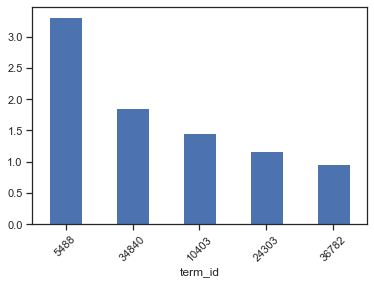

In [ ]:
EIG_PAIRS.exp_var.sort_values(ascending=False).head().plot.bar(rot=45)

## Pick Top K (10) Components

We pick these based on explained variance.

In [ ]:
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]

In [ ]:
COMPS

eig_val     20533      3532     21581     34916     22134     24746  \
PC0  0.030806  0.002415 -0.001972  0.006934  0.013316  0.023117  0.006533   
PC1  0.017285  0.010206  0.017135  0.015760  0.011370  0.005374  0.004297   
PC2  0.013582 -0.004366 -0.009162 -0.009684 -0.008939 -0.004689 -0.003803   
PC3  0.010830  0.006765  0.004035  0.002556  0.010318  0.001864  0.008353   
PC4  0.008896 -0.005178 -0.001337 -0.000162  0.009070  0.003193 -0.003670   
PC5  0.008382  0.020439 -0.010407  0.004413  0.004279  0.008928  0.005868   
PC6  0.007474 -0.009193 -0.004543 -0.019711 -0.009385  0.002552  0.006358   
PC7  0.006876 -0.018544  0.001637 -0.016709  0.002231  0.005849 -0.000301   
PC8  0.006536 -0.023118  0.003609 -0.002156 -0.002803 -0.004441  0.008129   
PC9  0.006173 -0.008698 -0.006844 -0.002773 -0.004791 -0.013705 -0.006346   

        30789     12385     24524  ...     32591     20661      5344  \
PC0  0.013179  0.004975 -0.000989  ... -0.005018  0.009262  0.001445   
PC1 -0.001858  0.011030  0.002911  ...  0.003947 -0.000830  0.000624   
PC2 -0.004208 -0.010710  0.009977  ...  0.002755 -0.000429  0.000221   
PC3  0.005042  0.002248  0.013187  ... -0.001250  0.002678  0.005441   
PC4  0.014423  0.003915 -0.009326  ...  0.001985  0.004096  0.002637   
PC5 -0.004342 -0.005711  0.012951  ...  0.000266  0.000971  0.002526   
PC6 -0.010939 -0.003501 -0.012905  ...  0.000117 -0.001139 -0.002525   
PC7 -0.024560 -0.002614 -0.022618  ... -0.008755 -0.000393 -0.006679   
PC8  0.015691  0.011886  0.010046  ... -0.000341 -0.006653  0.002701   
PC9  0.002165 -0.011661 -0.002171  ... -0.000603 -0.003959 -0.008207   

        34924     36782     24303     10403     34840      5488  exp_var  
PC0  0.008403 -0.009709  0.003876 -0.001678 -0.001929  0.003250     3.31  
PC1  0.000283 -0.008021  0.001415 -0.003203  0.001702  0.006888     1.86  
PC2 -0.001798  0.012586 -0.000516 -0.005814 -0.006902 -0.006266     1.46  
PC3  0.004886  0.000119  0.002448 -0.001994  0.004165  0.006930     1.17  
PC4  0.007643 -0.002872 -0.000660 -0.009771  0.005028 -0.003816     0.96  
PC5 -0.001951  0.001562  0.003880  0.005159 -0.005487 -0.005083     0.90  
PC6 -0.002012 -0.014886 -0.006177 -0.003513  0.009905  0.001264     0.80  
PC7  0.008361  0.002609 -0.003095  0.001476  0.013386  0.013499     0.74  
PC8 -0.002886  0.006885  0.003720 -0.007125  0.013790  0.007259     0.70  
PC9  0.003802  0.000950 -0.003903 -0.000154 -0.002067 -0.006424     0.66  

[10 rows x 3878 columns]

# Inspect terms associated with eigenvectors

In [ ]:
VOCAB.loc[[int(x) for x in EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).index], 'term_str']

term_id
5488          castle
34840         system
10403     dispatched
24303     occupation
36782       twilight
34924         talent
5344      carelessly
20661         lessen
32591      snatching
25958    perpetually
Name: term_str, dtype: object

## Show Loadings

Loadings sow the contribution of each term to the component. \
We'll just look at the topi 10 words for the first two components in the Book version.

In [ ]:
LOADINGS = COMPS[TERM_IDX].T
LOADINGS.index.name = 'term_id'

In [ ]:
LOADINGS.head().style.background_gradient()

In [ ]:
LOADINGS['term_str'] = LOADINGS.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)

In [ ]:
l0_pos = LOADINGS.sort_values('PC0', ascending=True).head(10).term_str.str.cat(sep=' ')
l0_neg = LOADINGS.sort_values('PC0', ascending=False).head(10).term_str.str.cat(sep=' ')
l1_pos = LOADINGS.sort_values('PC1', ascending=True).head(10).term_str.str.cat(sep=' ')
l1_neg = LOADINGS.sort_values('PC1', ascending=False).head(10).term_str.str.cat(sep=' ')

In [ ]:
print('Books PC0+', l0_pos)
print('Books PC0-', l0_neg)
print('Books PC1+', l1_pos)
print('Books PC1-', l1_neg)

Books PC0+ babbalanja thou media yoomy ahab ye thee thy mohi deck
Books PC0- elizabeth jane bennet sister colonel letter woodhouse mother wish feelings
Books PC1+ babbalanja media yoomy mohi thou lord mardi thee thy yillah
Books PC1- deck sailors boat mate ships crew sailor ahab officers cabin


# Project Docs onto New Subspace

We get the dot product of the DTM matrix and the new component matrix, which we will call DCM -- for document-component matrix. \
This has the effect of replacing the features of the DTM with the features of the transposed component matrix.

In [ ]:
DCM = TFIDF.dot(COMPS[TERM_IDX].T)

In [ ]:
DCM

PC0       PC1       PC2       PC3       PC4       PC5  \
book_id chap_num                                                               
105     1         0.298943 -0.049677 -0.031869 -0.224395 -0.098931 -0.002444   
        2         0.268598 -0.033825 -0.027377 -0.144410 -0.050217  0.019252   
        3         0.169367  0.038078 -0.050714  0.046572  0.042070 -0.078221   
        4         0.219184 -0.021023 -0.002472  0.063509  0.006093 -0.010654   
        5         0.308611  0.013522 -0.039165 -0.011848  0.019905  0.022591   
...                    ...       ...       ...       ...       ...       ...   
53861   8        -0.007745  0.001568  0.013178  0.060258 -0.014164 -0.015516   
        11        0.016594  0.035491  0.013300  0.069936  0.012091  0.012071   
        13       -0.072545  0.011768 -0.035236  0.039038 -0.017288 -0.006730   
        14       -0.036880  0.026186  0.017457  0.001750  0.016747  0.010342   
        15       -0.078296  0.147046 -0.061758  0.014907 -0.012495 -0.033910   

                       PC6       PC7       PC8       PC9  
book_id chap_num                                          
105     1         0.020632  0.052022  0.002506 -0.157794  
        2         0.006053  0.055330 -0.021043 -0.102094  
        3        -0.039840  0.045084  0.016722 -0.053424  
        4         0.034863  0.073867 -0.059799 -0.052014  
        5        -0.067069 -0.025902 -0.012548 -0.108287  
...                    ...       ...       ...       ...  
53861   8         0.015614  0.009546  0.147409 -0.018849  
        11       -0.069834 -0.044526  0.174868 -0.024858  
        13       -0.034785 -0.017749  0.182597 -0.030867  
        14       -0.011400 -0.007811  0.071453 -0.014777  
        15       -0.005587  0.026655  0.066558 -0.048707  

[1122 rows x 10 columns]

We add metadata to our new, reduced matrices for display purposes.

In [ ]:
DCM = DCM.join(LIB[['author','title']], on='book_id')

In [ ]:
DCM['doc'] = DCM.apply(lambda x: "{}-{}-{}".format(x.author, x.title, x.name[1]), 1)

In [ ]:
DCM.head().style.background_gradient()

# Visualize

In [ ]:
def vis_pcs(M, a, b, label='author', prefix='PC'):
    fig = px.scatter(M, prefix + str(a), prefix + str(b), 
                        color=label, 
                        hover_name='doc', marginal_x='box')
    fig.show()

## PC 0 and 1

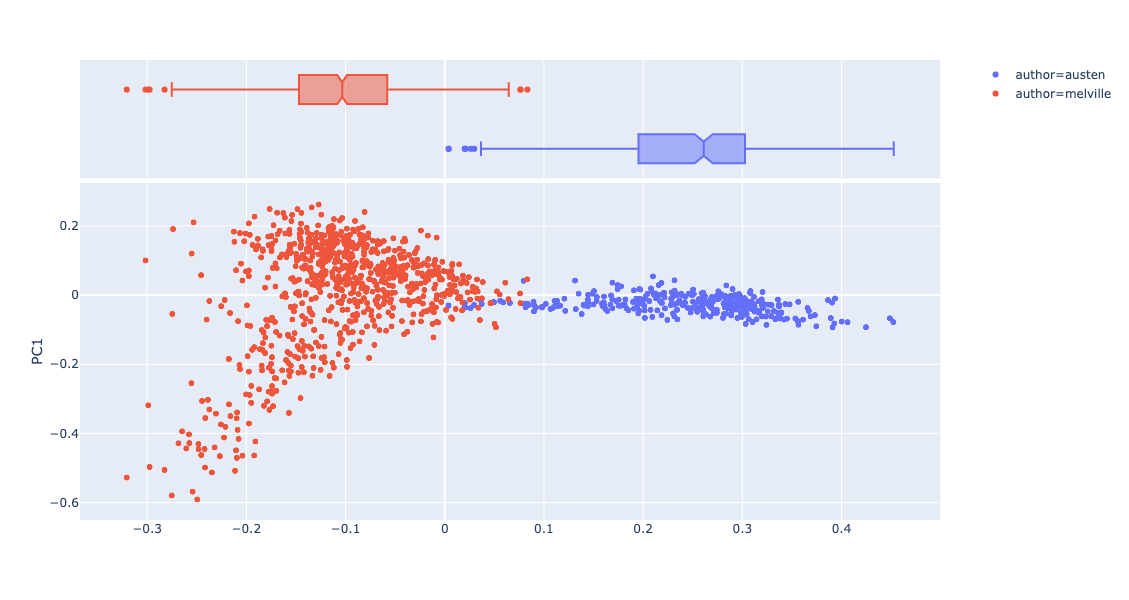

In [ ]:
vis_pcs(DCM, 0, 1)

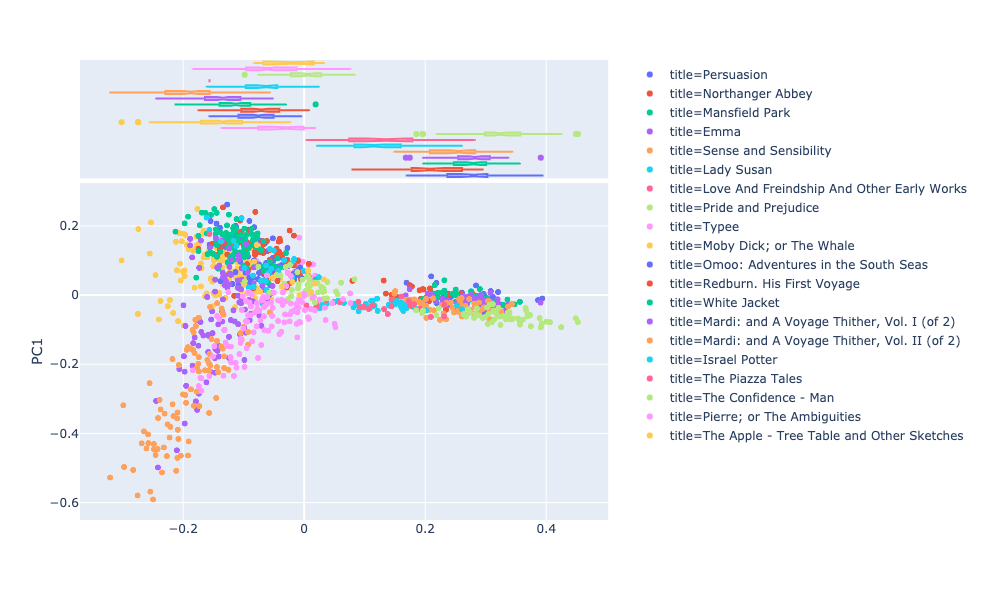

In [ ]:
vis_pcs(DCM, 0, 1, label='title')

## PC 1 and 2

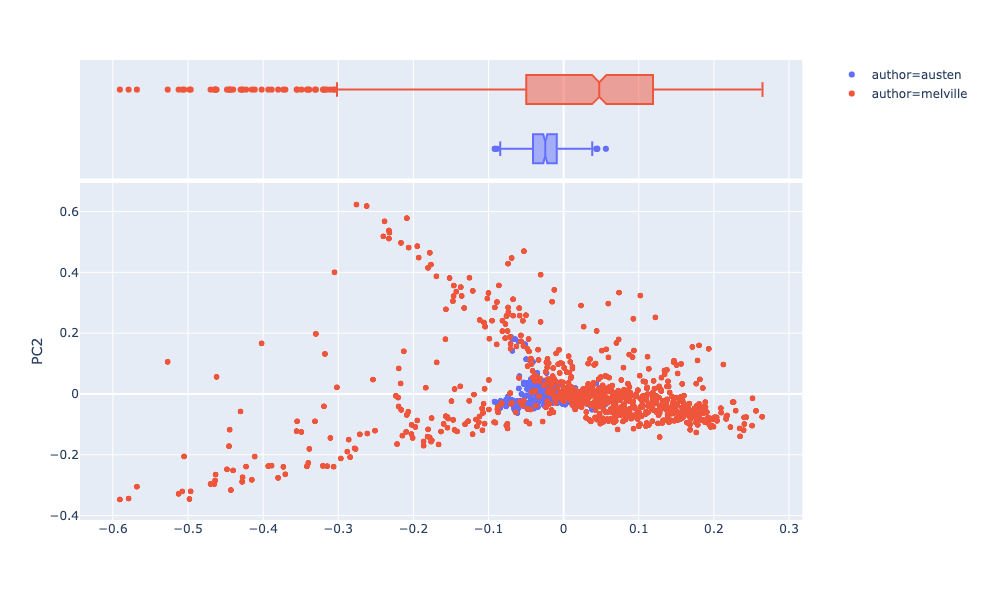

In [ ]:
vis_pcs(DCM, 1, 2)

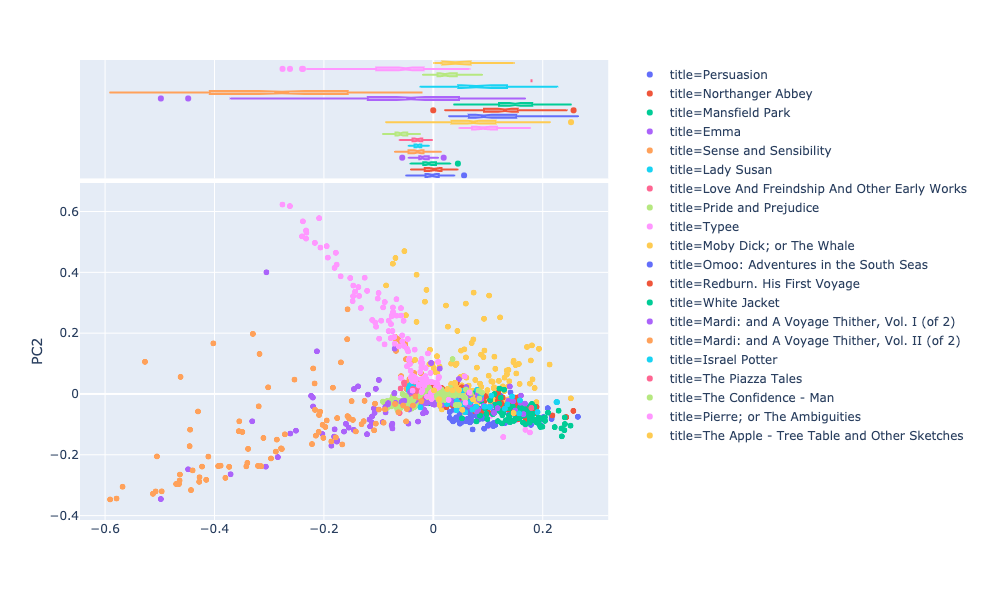

In [ ]:
vis_pcs(DCM, 1, 2, label='title')

## PC 2 and 3

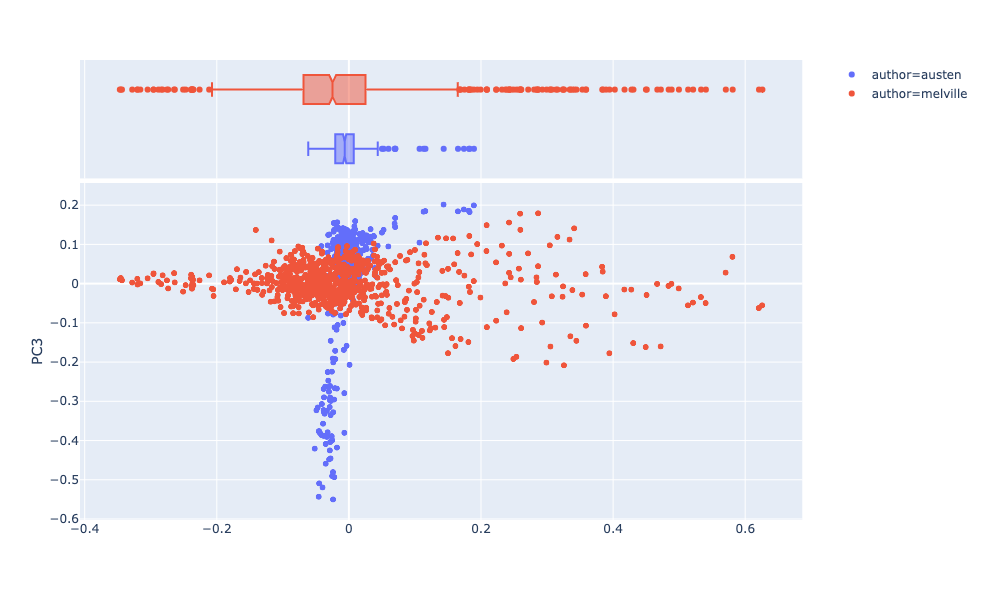

In [ ]:
vis_pcs(DCM, 2, 3)

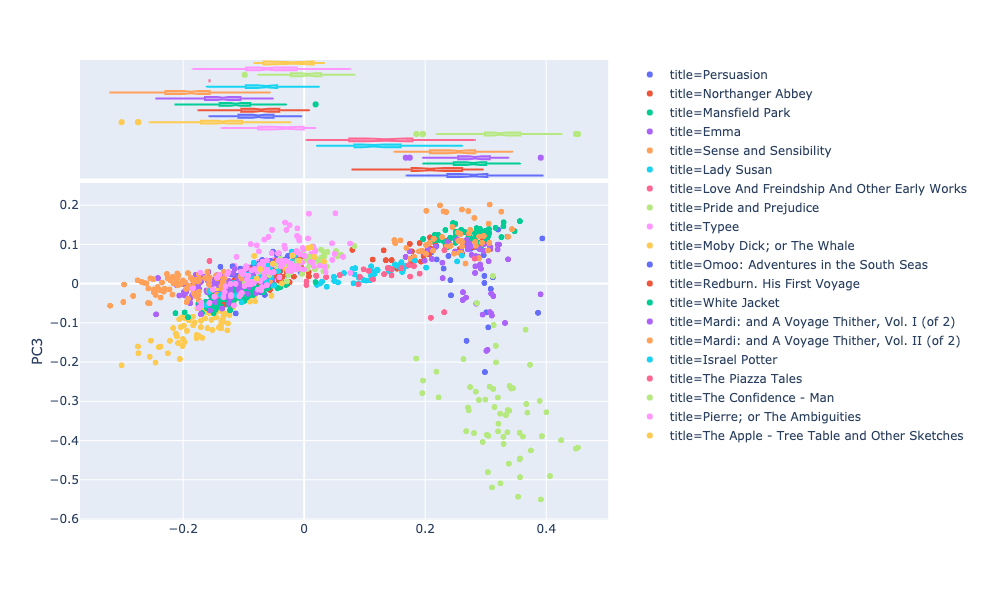

In [ ]:
vis_pcs(DCM, 0, 3, label='title')

## PC 3 and 4

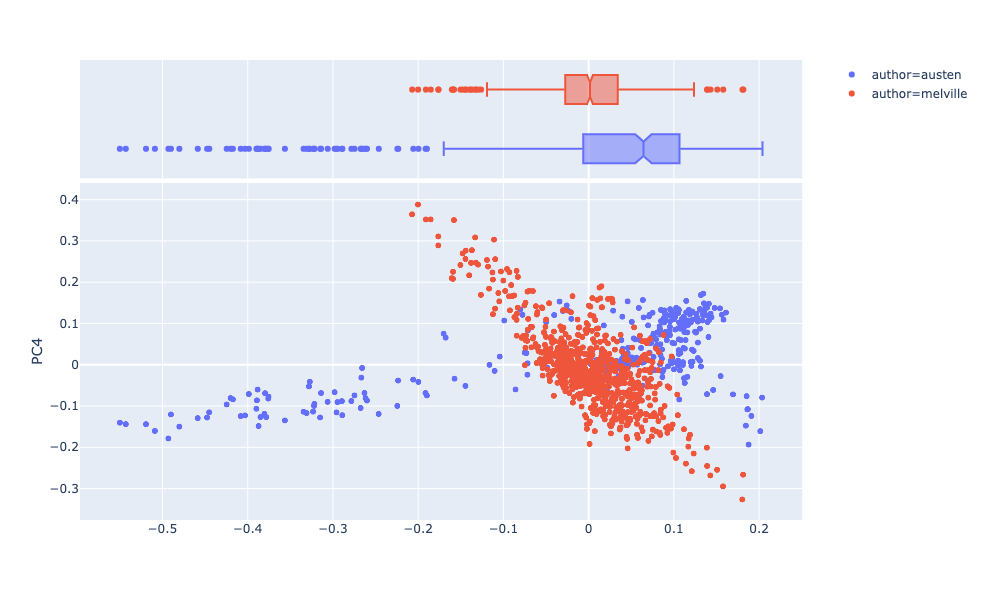

In [ ]:
vis_pcs(DCM, 3, 4, label='author')

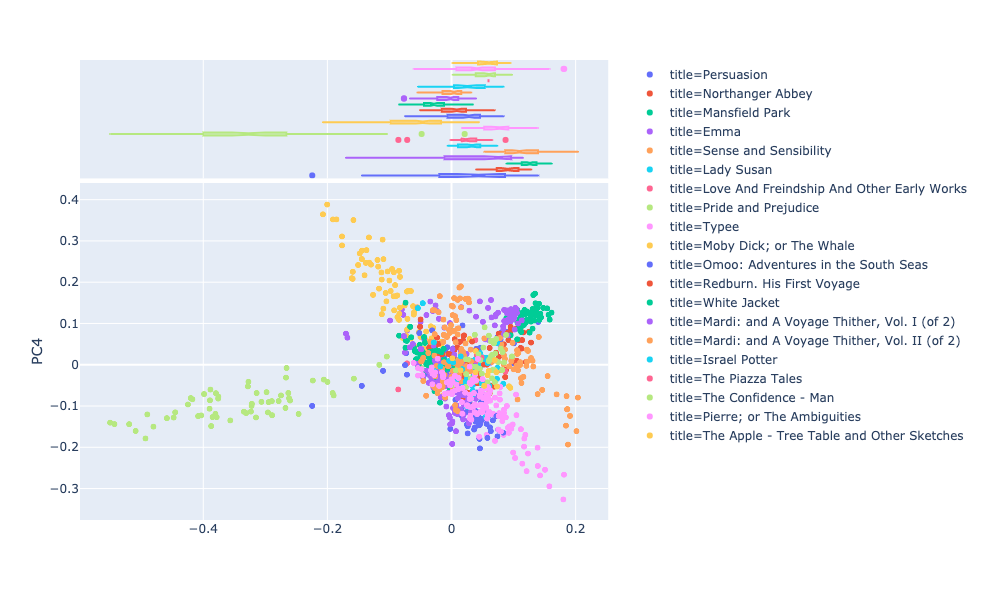

In [ ]:
vis_pcs(DCM, 3, 4, label='title')

# Compare to Scikit Learn

In [ ]:
pca_engine = PCA(n_components=10)

In [ ]:
DCM_sk = pd.DataFrame(pca_engine.fit_transform(TFIDF), index=TFIDF.index)
DCM_sk.columns = ['PC{}'.format(i) for i in DCM_sk.columns]
DCM_sk = DCM_sk.join(LIB[['author','title']], on='book_id')
DCM_sk['doc'] = DCM_sk.apply(lambda x: "{}-{}-{}".format(x.author, x.title, x.name[1]), 1)

In [ ]:
DCM_sk.head().style.background_gradient()

## PC 0 and 1

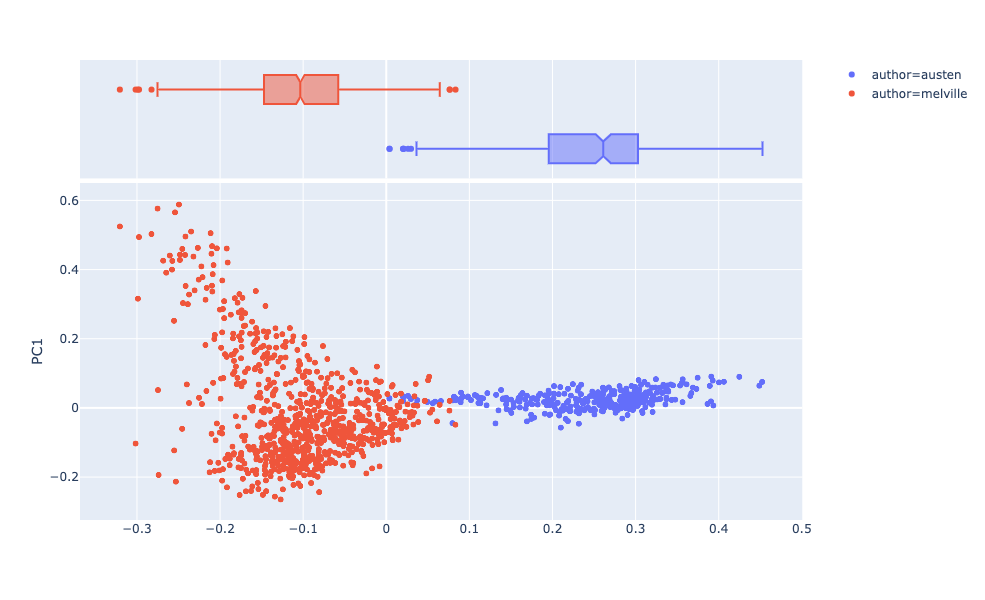

In [ ]:
vis_pcs(DCM_sk, 0, 1)

## PC 0 and 1

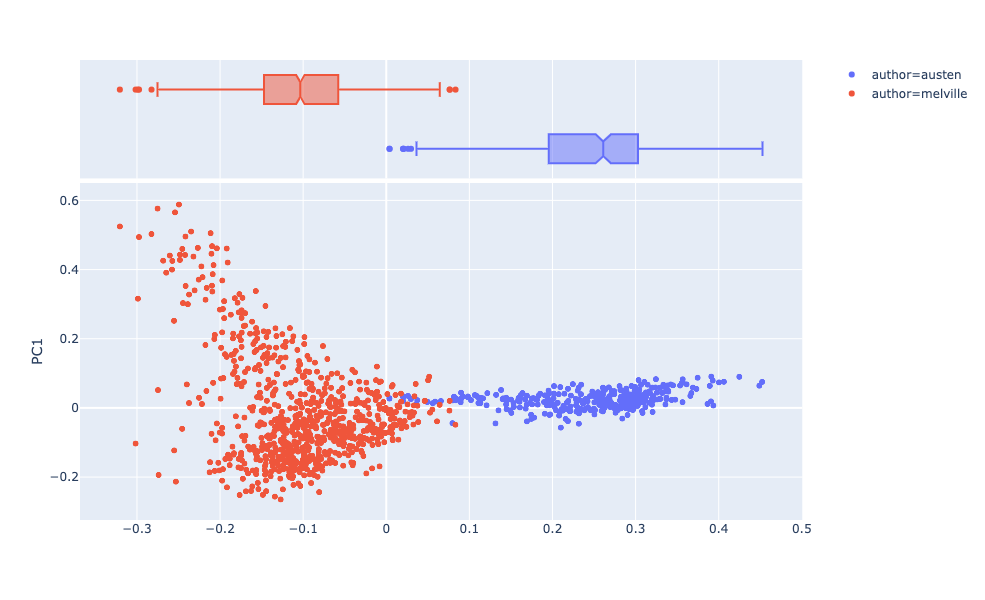

In [ ]:
vis_pcs(DCM_sk, 0, 1)

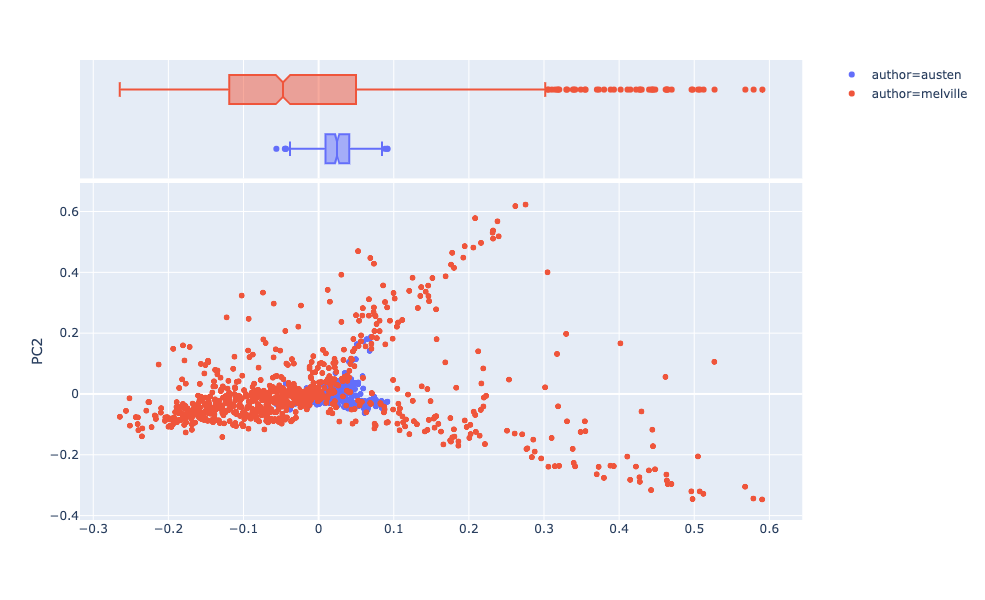

In [ ]:
vis_pcs(DCM_sk, 1, 2)

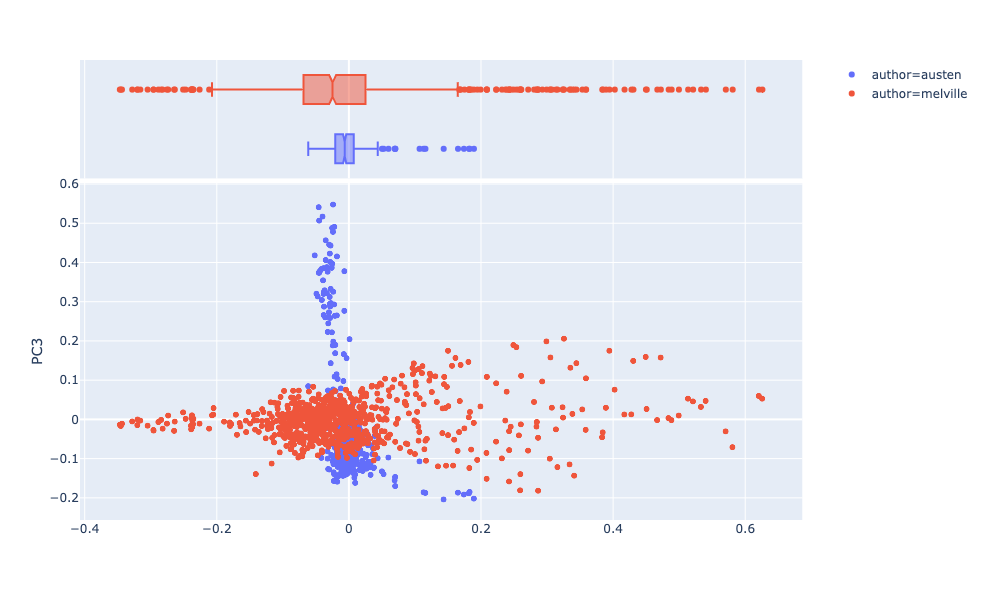

In [ ]:
vis_pcs(DCM_sk, 2, 3)

In [ ]:
px.scatter_3d(DCM_sk, 'PC0', 'PC1','PC2', color='title', hover_name='doc', height=1000, width=1200)

## Show Loadings

In [ ]:
LOADINGS_sk = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS_sk.columns = ["PC{}".format(i) for i in LOADINGS_sk.columns]

In [ ]:
LOADINGS_sk.index = TFIDF.columns
LOADINGS_sk.index.name = 'term_id'
LOADINGS_sk['term_str'] = LOADINGS_sk.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)

In [ ]:
pc0_pos = LOADINGS_sk.sort_values('PC0', ascending=False).head(10).term_str.str.cat(sep=' ')
pc0_neg = LOADINGS_sk.sort_values('PC0', ascending=True).head(10).term_str.str.cat(sep=' ')
pc1_pos = LOADINGS_sk.sort_values('PC1', ascending=False).head(10).term_str.str.cat(sep=' ')
pc1_neg = LOADINGS_sk.sort_values('PC1', ascending=True).head(10).term_str.str.cat(sep=' ')

In [ ]:
print('BOOKS PC0+', pc0_pos)
print('BOOKS PC0-', pc0_neg)
print('BOOKS PC1+', pc1_pos)
print('BOOKS PC1-', pc1_neg)

BOOKS PC0+ elizabeth jane bennet sister colonel letter woodhouse mother wish feelings
BOOKS PC0- babbalanja thou media yoomy ahab ye thee thy mohi deck
BOOKS PC1+ babbalanja media yoomy mohi thou lord mardi thee thy yillah
BOOKS PC1- deck sailors boat mate ships crew sailor ahab officers cabin


# SAVE

In [ ]:
DCM.to_csv('PCA_DCM_chaps.csv')
COMPS.to_csv('PCA_TCM_chaps.csv')
DCM.to_csv('PCA_DCM_books.csv')
COMPS.to_csv('PCA_TCM_books.csv')

# Note

> Mardi, and a Voyage Thither is Melville's third book. It is his first pure fiction work. It details (much like Typee and Omoo) the travelings of an American sailor who abandons his whaling vessel to explore the South Pacific. Unlike the first two, however, Mardi is highly philosophical and is said to be the first work to show Melville's true potential. The tale begins as a simple narrative, but quickly focuses upon discourse between the main characters and their interactions with different symbolic countries they encounter. While not as cohesive or lengthy as Moby-Dick, it shares many of the same themes and writing style.